# Part One: Mergin the files

In [1]:
import pandas as pd

In [2]:
tour_cap_nat = "tour_cap_nat.tsv"
tin00083 = "tin00083.tsv"

In [3]:
tcn = pd.read_table(tour_cap_nat)
tin = pd.read_table(tin00083)

In [4]:
print(tcn.columns.tolist()[:6])
print(tin.columns.tolist()[:5])

['accommod,unit,nace_r2,geo\\time', '2020 ', '2019 ', '2018 ', '2017 ', '2016 ']
['indic_is,ind_type,unit,geo\\time', '2012 ', '2013 ', '2014 ', '2015 ']


## General requrements 
### TOUR_CAP_NAT
#### Columns to use
* “accommod,unit,nace_r2,geo\time” and “2016 “

#### Rows to use: The first column is a composite of “accommod”, “unit”, “nace_r2” and “geo\time” separated by comma (“,”). You should only use rows where:
* “accommod” is “BEDPL”
* “unit” is “NR”
* “nace_r2” is “I551”

### TIN00083
#### Columns to use
* “indic_is,ind_type,unit,geo\time” and “2016”

#### Rows to use
The first column is a composite of “indic_is”, “ind_type”, “unit” and “geo\time” separated by comma (“,”). You should only use rows where:
* “ind_type” is “IND_TOTAL”

In [5]:
tcn_column = "accommod,unit,nace_r2,geo\\time"
tin_column = "indic_is,ind_type,unit,geo\\time"

tcn_year = "2016 "
tin_year = "2016 "

tcn_column_condition = "BEDPL,NR,I551,"
tin_column_condition = ",IND_TOTAL,"

tcn_selected = tcn.loc[tcn[tcn_column].str.startswith(tcn_column_condition, na=False)]
tin_selected = tin.loc[tin[tin_column].str.contains(tin_column_condition, na=False)]

In [6]:
# Utility functions

def is_valid_data(value: str) -> bool:
    """
    · Values suffixed with “ b” should be used (after removing the suffix).
    · Values suffixed with “ u” are unreliable and should be considered as missing data.
    · Values suffixed with “ bu” should be considered as missing data.
    """
    
    missing_value_indicators = [":", "u",]
    return not any((indicator in value for indicator in missing_value_indicators))

assert is_valid_data("601945")
assert is_valid_data("58 b")
assert not is_valid_data("113157 u")
assert not is_valid_data(": u")
assert not is_valid_data(":")
assert not is_valid_data(": c")
assert not is_valid_data("8966 bu")


def clean_data(data: str) -> int:
    """
    · The value “: ” signifies missing data.
    """
    
    if is_valid_data(data):
        if data.endswith("b"):
            data = data[:-1]
        return int(data.strip())
    else:
        return ": "

assert clean_data("601945") == 601945
assert clean_data("58 b") == 58
assert clean_data("113157 u") == ": "
assert clean_data(": u") == ": "
assert clean_data(":") == ": "
assert clean_data(": c") == ": "
assert clean_data("8966 bu") == ": "


def get_country_code(header: str) -> str:
    return header.split(",")[-1]

assert get_country_code("BEDPL,NR,I551,AT") == "AT"
assert get_country_code("BEDPL,NR,I551,CH") == "CH"
assert get_country_code("I_IUMD,IND_TOTAL,PC_IND,CH") == "CH"
assert get_country_code("I_IUMD,IND_TOTAL,PC_IND,EU27_2007") == "EU27_2007"


def country_code_is_valid(county_code: str) -> bool:
    """
    · Country codes “EA”, "EU27_2007", "EU27_2020", "EU28" should be treated the same as
    missing data and should be ignored.
    """
    
    invalid_county_codes = ["EA", "EU27_2007", "EU27_2020", "EU28"]
    return not county_code in invalid_county_codes

assert country_code_is_valid("AT")
assert country_code_is_valid("CH")
assert not country_code_is_valid("EA")
assert not country_code_is_valid("EU27_2007")
assert not country_code_is_valid("EU27_2020")
assert not country_code_is_valid("EU28")

### Country Code

In [7]:
def get_all_countries(tcn: pd.DataFrame,tin: pd.DataFrame) -> list:
    """The “Country Code” column should be distinct and should not contain missing data."""
    all_countries = []
    all_countries.extend(tcn[tcn_column].tolist())
    all_countries.extend(tin[tin_column].tolist())
    all_countries_clean = [get_country_code(x) for x in all_countries if country_code_is_valid(get_country_code(x))]
    return sorted(list(set(all_countries_clean)))


all_countries = get_all_countries(tcn_selected, tin_selected)
for country_code in all_countries:
    assert all_countries.count(country_code) == 1

### Percentage of individuals online

In [8]:
def get_perc_for_country_code(tin: pd.DataFrame, country_code: str) -> int:
    
    try:
        _df = tin.loc[tin[tin_column].str.endswith(country_code, na=False)][tin_year].values[0]
    except IndexError:
        return clean_data(":")
    return clean_data(_df)

assert get_perc_for_country_code(tin_selected, "AT") == 65
assert get_perc_for_country_code(tin_selected, "CZ") == ": "
assert get_perc_for_country_code(tin_selected, "AL") == ": "
assert get_perc_for_country_code(tin_selected, "FR") == 61
assert get_perc_for_country_code(tin_selected, "FFF") == ": "

### Number of Bed-places

In [9]:
def get_number_of_beds(tcn: pd.DataFrame, country_code: str) -> int:
    try:
        _df = tcn.loc[tcn[tcn_column].str.endswith(country_code, na=False)][tcn_year].values[0]
    except IndexError:
        return clean_data(":")
    return clean_data(_df)
    
assert get_number_of_beds(tcn_selected, "AT") == 601945
assert get_number_of_beds(tcn_selected, "SI") == 45716
assert get_number_of_beds(tcn_selected, "XK") == ": "
assert get_number_of_beds(tcn_selected, "RS") == ": "
assert get_number_of_beds(tcn_selected, "eee") == ": "

# To CSV

### The merged CSV file, with columns “Country Code”, “Percentage of individuals online” and “Number of Bed-places”.

In [10]:
the_merged_csv_file = "The merged CSV file.csv"

def to_csv(tcn: pd.DataFrame, tin: pd.DataFrame, file_name: str=the_merged_csv_file) -> None:
    _to_csv = {
        "Country Code": [],
        "Percentage of individuals online": [],
        "Number of Bed-places": []
    }
    all_countries = get_all_countries(tcn, tin)
    
    for country_code in all_countries:
        _to_csv["Country Code"].append(country_code)
        _to_csv["Percentage of individuals online"].append(get_perc_for_country_code(tin, country_code))
        _to_csv["Number of Bed-places"].append(get_number_of_beds(tcn, country_code))
    
    pd.DataFrame(_to_csv).to_csv(file_name, index=False)

to_csv(tcn_selected, tin_selected)

# Part Two: Visualizations

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
csv = pd.read_csv(the_merged_csv_file, index_col=0)

In [13]:
cc = "Country Code"
pio = "Percentage of individuals online"
nbp = "Number of Bed-places"

csv[pio] = csv[pio].replace(": ", 0).astype(int)
csv[nbp] = csv[nbp].replace(": ", 0).astype(int)

## Sorted by by highest "Percentage of individuals online"

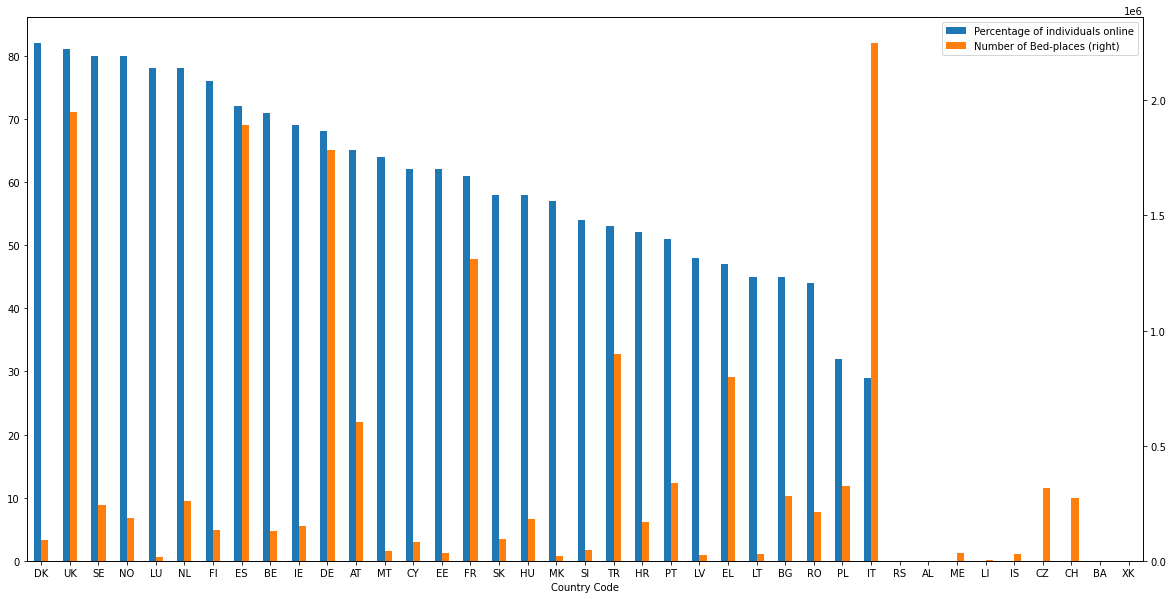

In [14]:
pio_csv = csv.sort_values(pio, ascending=False)

_ = pio_csv.plot(figsize=(20,10), kind="bar", secondary_y=nbp ,rot=0)
plt.show()

## Sorted by by highest "Number of Bed-places"

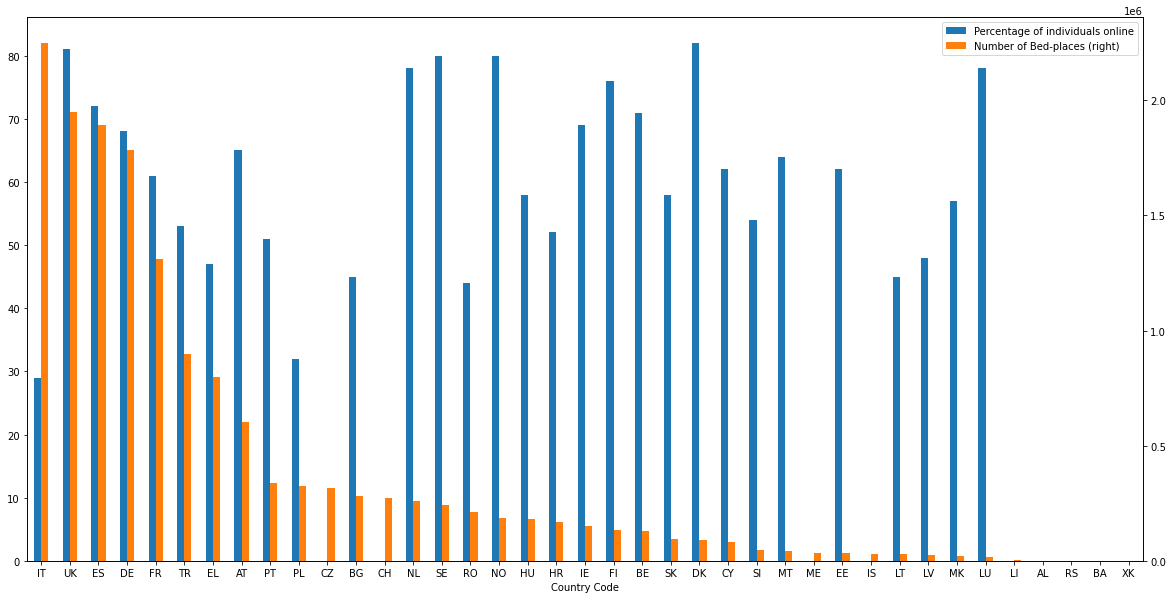

In [15]:
nbp_csv = csv.sort_values(nbp, ascending=False)

_ = nbp_csv.plot(figsize=(20,10), kind="bar", secondary_y=nbp, rot=0)
plt.show()